Importing libs

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import torch.optim as optim
from torchvision import datasets, models, transforms
import pennylane as qml

GPU

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Transforms

In [69]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [70]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

Importing data

In [71]:
batch_size = 4 

In [72]:
data_dir = 'hymenoptera_data/'
sets = ['train', 'val']

image_datasets = {set: datasets.ImageFolder(os.path.join(data_dir, set),
                                          data_transforms[set])
                  for set in sets}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size,
                                             shuffle=True, num_workers=2)

dataset_sizes = {set: len(image_datasets[set]) for set in sets}
classes = image_datasets['train'].classes
classes

['ants', 'bees']

In [73]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Functions for model training and testing 

In [75]:
def train(model, train_loader, criterion, optimizer, losses, num_epochs=100):
    for epoch in range(num_epochs):
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        losses.append(running_loss)
        print(f"Epoch {epoch + 1} / {num_epochs}")
    print('Training is finished')
    return model

In [76]:
def predict(model, test_loader):
  n_samples = 0
  n_correct = 0
  n_class_samples = np.zeros(2)
  n_class_correct = np.zeros(2)
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)
    _, predictions = torch.max(output, -1)
    n_samples += labels.size(0)
    n_correct += (predictions==labels).sum().item()
    
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predictions[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Choosing training params and fine tuning

In [78]:
losses = list()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
lr_step = 3 * 10 ** -4
model = model.to(device)

In [77]:
# using pretrained resnet 18 with last layer fine tuning
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model and evaluating accuracy

In [79]:
model = train(model, train_loader, criterion, optimizer, num_epochs=50)

TypeError: train() missing 1 required positional argument: 'losses'

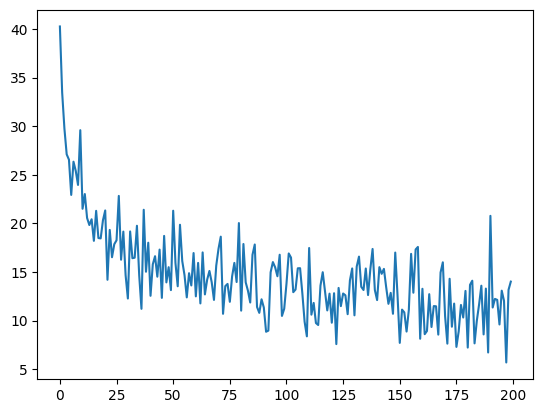

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

In [ ]:
predict(model, test_loader)

Accuracy of the network: 82.3529411764706 %
Accuracy of ants: 81.42857142857143 %
Accuracy of bees: 83.13253012048193 %


Hybrid NN with quantum layers design

In [ ]:
n_qubits = 4
q_depth = 6
q_delta = 0.01

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")
def quantum_circuit(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(q_input_features[i], wires=i)
    for k in range(q_depth):
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        for i in range(n_qubits):
            qml.RY(q_weights[k][i], wires=i)
            qml.RX(q_weights[k][i], wires=i)
            qml.RZ(q_weights[k][i], wires=i)    
    return list(qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits))

In [ ]:
class QuantumNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.classical_layer = nn.Linear(num_ftrs, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.classificator = nn.Linear(4, 2)
    
    def forward(self, input_features=512):
        pre_out = self.classical_layer(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_circuit(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.classificator(q_out)

Training and testing model

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = QuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=lr_step)

In [ ]:
losses_hybrid = list()

In [80]:
model_hybrid = train(model_hybrid, train_loader, criterion, optimizer_hybrid, losses_hybrid, num_epochs=20)

Epoch 1 / 20
Epoch 2 / 20
Epoch 3 / 20
Epoch 4 / 20
Epoch 5 / 20


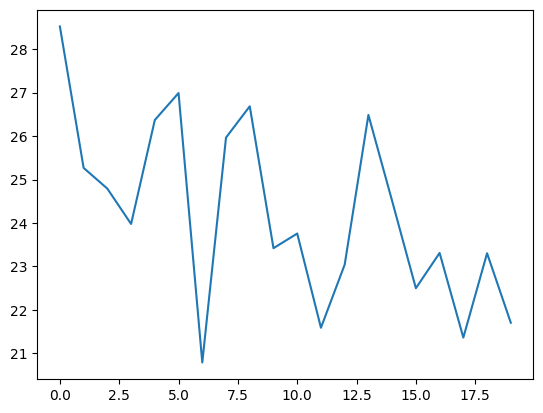

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(losses_hybrid)), np.array(losses_hybrid))
plt.show()

In [ ]:
predict(model_hybrid, test_loader)

Accuracy of the network: 87.58169934640523 %
Accuracy of ants: 90.0 %
Accuracy of bees: 85.5421686746988 %
